In [1]:
papdir    =  '..'
outdir    =  '{0}/out'.format(papdir)
figdir    =  '{0}/figs'.format(papdir)
datdir     = '{0}/neutrophil_data'.format(papdir)
eigdir     = '{0}/eig'.format(outdir)

In [2]:
import numpy as np
import scipy as scipy
import sys
import copy
import os

import sys
sys.path.append('{0}/python'.format(papdir))
import myfun as mf
import pickle as pkl

from scipy.spatial import distance as sc_dist

import matplotlib
from matplotlib import gridspec, rc, colors
from matplotlib.ticker import LogLocator, LogFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture as GMM

rc('text',usetex=True)#, latex.preamble = r'\usepackage{{amsmath}}')

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import json

In [3]:
def dens_norm(dens, eps=1e-12):
    dens2 = np.log10(dens,where=dens>1e-12,out=np.zeros_like(dens))
    dens_min, dens_max = np.amin(dens2[dens2!=0]), np.amax(dens2[dens2!=0])
    dens3 = (dens2-dens_min)/(dens_max-dens_min)
    dens3[dens<1e-12]=-1
    return dens3

def get_bin_mesh(xbinlim, ybinlim):
    xbctr = 0.5*(xbinlim[1:]+xbinlim[:-1])
    ybctr = 0.5*(ybinlim[1:]+ybinlim[:-1])
    return np.meshgrid(xbctr, ybctr)

In [4]:
pst_eig1     = np.load('{0}/dat_eval.npy'.format(eigdir))[:,0]
pst_pc1      = np.load('{0}/dat_evec.npy'.format(eigdir))[:,0]
mu_gexp      = np.load('{0}/high_var_gexp_trajs.npy'.format(datdir))
pc1_proj     = np.load('{0}/gexp_pc1_proj.npy'.format(datdir))

In [5]:
#COMPUTE THE PROJECTIONS HERE...
print('loading gene expression matrix')
gexp_fname = '{0}/gene_expr.npz'.format(datdir)
gexp_sp    = scipy.sparse.load_npz(gexp_fname) # WT: 18.3 seconds
pc1_proj   = gexp_sp.dot(pst_pc1.T)
np.save('{0}/gexp_pc1_proj.npy'.format(datdir),pc1_proj)

loading gene expression matrix


In [6]:
pst_fname    = '{0}/pseudotime.txt'.format(datdir)
neut_psts    = np.genfromtxt(pst_fname, skip_header=True, dtype='int')
with open('{0}/bin_cidxs.pkl'.format(eigdir),'rb') as f:
    bin_cidxs = pkl.load(f)

In [7]:
gnm_fname  = '{0}/gene_names.txt'.format(datdir)
gnms     = np.genfromtxt(gnm_fname,dtype='str')

In [8]:
pc1_corr = pst_pc1.dot(pst_pc1.T)

In [9]:
gexp_norm = np.linalg.norm(mu_gexp,axis=1)
gexp_norm_outer = np.outer(gexp_norm, gexp_norm)
mu_gexp_cc = mu_gexp.dot(mu_gexp.T)/gexp_norm_outer

In [10]:
nt            = len(bin_cidxs)
nbranch       = 2
bifts         = np.array([87,109])
evec_ts       = np.hstack([[0],bifts])
split_ts      = np.hstack([evec_ts,[nt]])
dat           = pc1_proj[bin_cidxs[bifts[1]],bifts[1]].reshape(-1,1)

In [11]:
gmm   = GMM(n_components=2)
mygmm = gmm.fit(dat)

gmm_preds     = [mygmm.predict(pc1_proj[bin_cidxs[t],bifts[1]].reshape(-1,1)) for t in np.arange(nt)]
gmm_pred_idxs = [[np.where(gmm_preds[t]==i)[0] for i in range(nbranch)] for t in range(nt)]

In [12]:
nc1 = np.array([len(gmm_pred_idxs[t][1]) for t in range(nt)])
t0 = np.where(nc1<1000)[0][0]

traj_idxs_split        = [np.hstack([bin_cidxs[t] for t in range(split_ts[i],split_ts[i+1])]) 
                   for i in range(len(split_ts)-1)]
branch_cidxs_flat      = [np.hstack([bin_cidxs[t][gmm_pred_idxs[t][i]] for t in range(t0, nt)]) 
                     for i in range(nbranch)]
traj_idxs_split_branch = [traj_idxs_split[0]]+branch_cidxs_flat

In [13]:
evec_dists = sc_dist.squareform(sc_dist.pdist(pst_pc1))
evec_ts2  = [evec_ts[i]+np.argmin(np.sum(evec_dists[evec_ts[i]:evec_ts[i+1],evec_ts[i]:evec_ts[i+1]],axis=1)) for i in range(len(evec_ts)-1)]
evec_ts2 += [evec_ts[-1]]

In [14]:
print('loading gene expression matrix')
gexp_fname = '{0}/gene_expr.npz'.format(datdir)
gexp_sp    = scipy.sparse.load_npz(gexp_fname) # WT: 18.3 seconds
gexp_full  = gexp_sp.toarray() # WT: 3 min 55 seconds

loading gene expression matrix


In [15]:
gexp_l2_norm = np.linalg.norm(gexp_full, axis=1)
gexp_l2_normd = gexp_full.T / gexp_l2_norm
pc1_costh = pst_pc1.dot(gexp_l2_normd)#.dot(pst_pc1.T)
np.save('{0}/gexp_costh.npy'.format(datdir),pc1_costh)

In [16]:
pc1_costh = np.load('{0}/gexp_costh.npy'.format(datdir))

In [17]:
nc_all = np.array(list(map(len, bin_cidxs)))

In [18]:
npst  = len(bin_cidxs)
nbif  = len(bifts) 
nevec = len(evec_ts2)
hmaxs = np.array([np.amax(pc1_costh[bift]) for bift in evec_ts2])
hmins = np.array([np.amin(pc1_costh[bift]) for bift in evec_ts2])

bwidth = 0.1
nbins = int(2./bwidth)+2
bmax = 1+bwidth/2
hbins = np.array([np.linspace(-bmax,bmax,nbins) for i in range(nevec)])

sgns  = np.array([-1,-1,1])
hbins = np.array([np.sort(hbins[i]*sgns[i]) for i in range(len(hbins))])
bif_proj_hists  = np.array([[np.histogram(sgns[i]*pc1_costh[evec_ts2[i], bin_cidxs[t]], bins=hbins[i])[0] 
                            for t in range(npst)] 
                          for i in range(nevec)])
bif_proj_dens_hists = np.array([[np.histogram(sgns[i]*pc1_costh[evec_ts2[i], bin_cidxs[t]], bins=hbins[i], 
                                              density=True)[0] 
                            for t in range(npst)]
                          for i in range(nevec)])
hbin_mids = 0.5*(hbins[:,1:]+hbins[:,:-1])

In [19]:
# pathway loading
fnm    = "{0}/mmu00001.json".format(datdir)
mmu_ko = json.load(open(fnm))

gnm_ko    = {}
ko_id_def = [{},{},{},{}]
ko_gid_gnm = {}
ko_gnm_gid = {}
proc_gnms = [{},{},{}]

for di in mmu_ko['children']:
    id1,def1          = di['name'].split(' ',1)
    id1               = int(id1)
    ko_id_def[0][id1] = def1
    
    for dj in di.get('children',[]):
        id2,def2          = dj['name'].split(' ',1)
        id2               = int(id2)
        ko_id_def[1][id2] = def2
        
        for dk in dj.get('children',[]):
            id3,def3          = dk['name'].split(' ',1)
            id3               = int(id3)
            ko_id_def[2][id3] = def3
            
            for dl in dk.get('children',[]):
                id4,def4          = dl['name'].split(' ',1)
                id4               = int(id4)
                ko_id_def[3][id4] = def4
                gnm               = def4.split(';',1)[0]
                
                ko_gid_gnm[id4] = gnm
                ko_gnm_gid[gnm] = id4
                
                gnm_ko[gnm] = gnm_ko.get(gnm,[[],[],[]])
                
                gnm_ko[gnm][0].append(id1)
                gnm_ko[gnm][1].append(id2)
                gnm_ko[gnm][2].append(id3)
                
                proc_gnms[0][id1] = proc_gnms[0].get(id1,[])+[gnm]
                proc_gnms[1][id2] = proc_gnms[1].get(id2,[])+[gnm]
                proc_gnms[2][id3] = proc_gnms[2].get(id3,[])+[gnm]

ko_id_arr  = [np.array(list(zip(range(len(x)),x.keys()))) for x in ko_id_def]
kidx2ko_id = [dict(zip(range(len(x)),x.keys())) for x in ko_id_def]
ko_id2kidx = [dict(zip(x.keys(),range(len(x)))) for x in ko_id_def]

strip_strs = ['Protein families: ',' not elsewhere classified', 'Coronavirus disease - ',' formation', ' processes',
             'pathway', 'molecules', ]
repl_strs = {'and':'&', 'system':'sys', 
             'Infectious disease: bacterial':'Bacterial disease',
            'Infectious disease: viral':'Viral disease',
            'Neurodegenerative':'Neurodegen.',
            'information':'info',
            'Domain-containing': 'Domain-cont.',
            'Messenger RNA':'mRNA'}

def fix_name(nm):
    nm2 = nm
    for s in strip_strs:
        nm2 = nm2.replace(s, '')
    for s1,s2 in repl_strs.items():
        nm2 = nm2.replace(s1,s2)
    
    #nm2 = nm2[0].upper()+nm2[1:]
    return nm2

ko_id_def2 = [{k:fix_name(v) for k,v in y.items()} for y in ko_id_def]

In [20]:
ntop_proc  = 5
nproc_lev  = len(proc_gnms)
pst_pc1_sq = pst_pc1**2
ng         = pst_pc1_sq.shape[1]


proc_wts  = [np.zeros((len(x),len(evec_ts))) for x in ko_id_def]
proc_cts  = [np.zeros(len(x))                for x in ko_id_def]

for gidx in range(ng):
    gnm = gnms[gidx]
    if gnm in gnm_ko:
        for i in range(nproc_lev):
            for proc in gnm_ko[gnm][i]:
                kidx = ko_id2kidx[i][proc]
                proc_cts[i][kidx] += 1
                for ti,t in enumerate(evec_ts2):
                    proc_wts[i][kidx, ti] += pst_pc1_sq[t, gidx]

proc_wts_norm = [np.divide(proc_wts[i].T,proc_cts[i],where=proc_cts[i]!=0,out=np.zeros_like(proc_wts[i].T)).T 
                 for i in range(nproc_lev)]

top_proc_idxs      = [[np.argsort(-proc_wts[i][:,ti])[0:ntop_proc] for ti in range(len(evec_ts))] 
                      for i in range(nproc_lev)]
top_proc_idxs_flat = [np.hstack(x) for x in top_proc_idxs]
unq_idx            = [np.unique(x, return_index=True)[1] for x in top_proc_idxs_flat]
top_proc_idxs_flat = [top_proc_idxs_flat[i][np.sort(unq_idx[i])] for i in range(len(top_proc_idxs_flat))]

In [21]:
meta_fname = '{0}/metadata.txt'.format(datdir)

print('loading cluster labels and SPRING positions')
dtp      = np.dtype([('Library Cell', np.unicode_, 16),('barcode', np.unicode_, 20),
              ('Time point', int),('Starting population', np.unicode_, 20),
               ('Cell type annotation', np.unicode_, 60),
               ('Well', int), ('SPRING-x', np.float64), ('SPRING-y', np.float64)])

metadata = np.genfromtxt(meta_fname, delimiter='\t',skip_header=1, dtype=dtp)

loading cluster labels and SPRING positions


/var/folders/0h/m5bz9gw55x73mtvt8hyl1cd40000gs/T/ipykernel_67236/2678330389.py:258: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=7
/var/folders/0h/m5bz9gw55x73mtvt8hyl1cd40000gs/T/ipykernel_67236/2678330389.py:268: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color(panecolor)
/var/folders/0h/m5bz9gw55x73mtvt8hyl1cd40000gs/T/ipykernel_67236/2678330389.py:269: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color(panecolor)
/var/folders/0h/m5bz9gw55x73mtvt8hyl1cd40000gs/T/ipykernel_67236/2678330389.py:270: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color(panecolor)


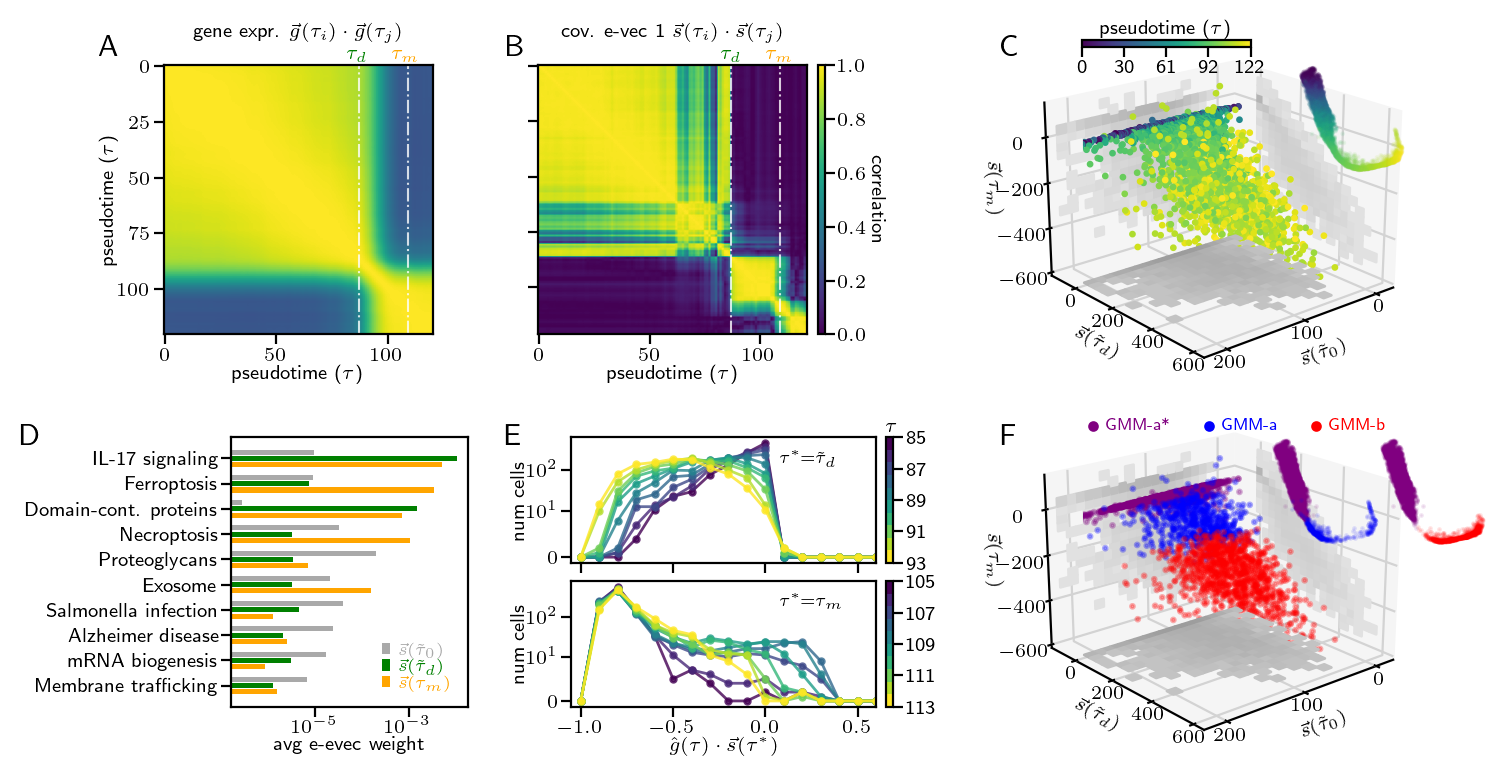

In [22]:
plt.style.reload_library()
plt.style.use('{0}/sty/one_col_fig_7.mplstyle'.format(papdir))
plt.rcParams['grid.color'] = "lightgray"

wfrac, hfrac = 4,4

left_marg_wid = 4
awid = 8
ab_spc = 3
bwid = awid
bbleg_spc = 0.25
bleg_wid  = 0.25
#blegc_spc = 3
cwid      = 9
cleg_leftpad_wid  = 0.5
cleg_wid=5

dmarg_wid = 2
dwid = 7
de_spc = 3
ewid = 9
eeleg_spc = 0.25
eleg_wid = 0.25
elegf_spc = 5

top_marg_ht = 1
cin_ht = 3
cleg_ht = 0.25
clegc_spc = 0.5
aht = 8
ad_spc = 3
eht = 3.75
eespc = 0.5
#fin_ht = 

wid1 = awid - dmarg_wid
wid2 = dwid - ab_spc - wid1
wid3 = bwid - de_spc - wid2
wid4 = ewid - wid3 - bbleg_spc - bleg_wid

wds = np.array([
    left_marg_wid,
    dmarg_wid,
    wid1,
    ab_spc,
    wid2,
    de_spc,
    wid3,
    bbleg_spc,
    bleg_wid,
    wid4,
    eeleg_spc,
    eleg_wid,
    elegf_spc,
    cleg_leftpad_wid,
    cleg_wid,
    cwid - cleg_wid - cleg_leftpad_wid
])

ht1 = cin_ht - eht
hts = np.array([
    top_marg_ht,
    cleg_ht,
    clegc_spc,
    cin_ht,
    aht - cin_ht,
    ad_spc,
    eht,
    ht1,
    eespc - ht1,
    eht
])

wds = np.array(wfrac*wds,dtype = int)
hts = np.array(hfrac*hts,dtype = int)


rs = np.cumsum(hts) # starting rows
cs = np.cumsum(wds) # starting cols

nr = np.sum(hts)
nc = np.sum(wds)

wid = 22/2.54
ht  = wid*nr/nc


fig = plt.figure(figsize=(wid, ht), dpi=200)

gs = gridspec.GridSpec(nr, nc)

axA  = plt.subplot( gs[rs[2]:rs[4], cs[0]:cs[2]])
axB  = plt.subplot( gs[rs[2]:rs[4], cs[3]:cs[6]])
axBL = plt.subplot( gs[rs[2]:rs[4], cs[7]:cs[8]])
axC  = plt.subplot( gs[rs[2]:rs[4], cs[12]:    ], projection='3d') 
axCL = plt.subplot( gs[rs[0]:rs[1], cs[13]:cs[14]]) 

axD    = plt.subplot( gs[rs[5]:rs[9], cs[1]:cs[4]])
axE1   = plt.subplot( gs[rs[5]:rs[6], cs[5]:cs[9]]) 
axE2   = plt.subplot( gs[rs[8]:rs[9], cs[5]:cs[9]])
axE1L  = plt.subplot( gs[rs[5]:rs[6], cs[10]:cs[11]]) 
axE2L  = plt.subplot( gs[rs[8]:rs[9], cs[10]:cs[11]]) 
axF    = plt.subplot( gs[rs[5]:rs[9], cs[12]:      ], projection='3d')

caps = ['A','B','C','D','E','F']

rcxy = [
    [rs[1], 0     , 0, 10], #A
    [rs[1], cs[2] , 0, 10], #B
    [rs[1], cs[11], 0, 15], #C
    [rs[5], 0     , 0, -1], #D
    [rs[5], cs[4] , 0, 5], #E
    [rs[5], cs[11], 0, 15] #F
]

for i in range(len(caps)):
    r,c,dr,dc = rcxy[i]
    cap_ax=plt.subplot(gs[r:r+1,c:c+1])
    cap_ax.text(s=caps[i], x=dc, y=dr,fontsize=11, fontweight='bold')
    cap_ax.axis('off')
    
#####################################
########### A and B #################
########## correlation plots ########
#####################################
pst_ax_label = r'pseudotime ($\tau$)'
im1 = axA.imshow(mu_gexp_cc,vmin=0,vmax=1)
im2 = axB.imshow(np.abs(pc1_corr),vmin=0,vmax=1)

for ax in [axA, axB]:
    ax.set_xticks([0,50,100])
    ax.set_xlabel(pst_ax_label)

axA.set_ylabel(pst_ax_label)
axB.set_yticklabels([])
plt.colorbar(im1, cax=axBL)
axBL.set_ylabel('correlation', rotation=270, labelpad=7)
axA.set_title('gene expr. '+r'$\vec{g}(\tau_i)\cdot \vec{g}(\tau_j)$', pad = 10)
axB.set_title('cov. e-vec 1  '+r'$\vec{s}(\tau_i)\cdot \vec{s}(\tau_j)$', pad=10)

######################
# bifurcation lines ##
######################
bifcols  = ['green','orange']
bcol = ['darkgray']+bifcols

zord     = [1,1]
lws      = [0.75,0.75]
tau_min  = np.array([0,0])
tau_min  = np.vstack([tau_min, tau_min]).T
uselinecols  = [False, False]
lss      = ['-.','-.']

#bifts = np.array([t_bifurc,t_bifurc_pf])
bifnms = [r'$\tau_{d}$',r'$\tau_{m}$']
bifxs  = (np.array([bifts]) - tau_min)/(npst - tau_min) #[0.8,0.6] #bifts / tf
for j in range(len(bifts)):
    for i,ax in enumerate([axA, axB]):
        ax.text(s=bifnms[j],x=bifxs[i][j],y=1.01,transform=ax.transAxes,color=bifcols[j],
                 horizontalalignment = 'center', verticalalignment='bottom',fontsize=7)
        ax.axvline(bifts[j],color='white', 
                           linestyle = lss[j], alpha=0.8,zorder=zord[i],lw=lws[i])
##############################
####### C and F ##############
#### e-vec scatter plot ######
##############################

scat_skip = 10
inset_markersize=0.5
inset_alpha = 0.1
traj_idxs = np.array(neut_psts[::scat_skip,0],dtype='int')
traj_psts = np.array(neut_psts[::scat_skip,1],dtype='int')

springX = metadata['SPRINGx'][traj_idxs]
springY = metadata['SPRINGy'][traj_idxs]

axCin    = axC.inset_axes([0.8, 0.6, 0.4, 0.4],transform=axC.transAxes)
#axFin    = axF.inset_axes([0.8, 0.6, 0.4, 0.4],transform=axF.transAxes)
axFin1    = axF.inset_axes([0.7, 0.6, 0.4, 0.4],transform=axF.transAxes)
axFin2    = axF.inset_axes([1.1, 0.6, 0.4, 0.4],transform=axF.transAxes)
axFins    = [axFin1, axFin2]

# plot points in neutrophil trajectory
colmapC = plt.cm.viridis(np.linspace(0,1,traj_idxs.shape[0]))
colsC   = colmapC[np.array(traj_psts/scat_skip,dtype='int')]

proj = pc1_proj[traj_idxs][:,evec_ts2].T
axC.scatter(proj[0],proj[1],proj[2], c=colsC, alpha=1,s=2)
axCin.scatter(springX,springY, c=colsC,alpha=inset_alpha,s=inset_markersize)

cmap   = plt.cm.get_cmap('viridis', traj_idxs.shape[0])
sm     = plt.cm.ScalarMappable(cmap=cmap)
nticks = 5
plt.colorbar(sm, cax=axCL, orientation='horizontal',ticks=np.linspace(0,1,nticks))
axCL.set_xticklabels(np.array(np.around(np.linspace(0,npst,nticks)),dtype='int'))#, fontsize=ab_cap_fs)
axCL.set_title(pst_ax_label)#, fontsize=ab_cap_fs)

#### for axF
clust_cols = ['red', 'blue']
colsF      = np.array(['purple']+clust_cols)
clabs      = np.array(['GMM-a*', 'GMM-b', 'GMM-a'])
disp_ord   = np.array([0,2,1])
for i in disp_ord: # best order for display (?)
    _,idxs,_ = np.intersect1d(traj_idxs, traj_idxs_split_branch[i], return_indices=True)
    projF = pc1_proj[traj_idxs[idxs]][:,evec_ts2].T
    axF.scatter(projF[0],projF[1],projF[2], c=colsF[i],alpha=0.3, s=2,label=clabs[i])
    #axFin.scatter(springX[idxs],springY[idxs], c=colsF[i],alpha=inset_alpha, s=inset_markersize)

    if i == 0:
        for axFin in axFins:
            axFin.scatter(springX[idxs],springY[idxs], c=colsF[i],alpha=inset_alpha, s=inset_markersize)
    else:
        axFins[disp_ord[i]-1].scatter(springX[idxs],springY[idxs], c=colsF[i],alpha=inset_alpha, 
                                      s=inset_markersize)


leg = axF.legend(labelspacing=0,handlelength=0.5, labelcolor=colsF[disp_ord], handletextpad=0.5, 
       frameon=False, markerscale=2, fontsize=6, loc=[-0,0.99], ncol=3)

for lh in leg.legendHandles:
    lh.set_alpha(1)
#axFin.legend(labelspacing=0,handlelength=0.5)#,labelcolor='mfc')

# ### inset formatting ###

springXlims = [np.amin(springX), np.amax(springX)]
springYlims = [np.amin(springY), np.amax(springY)]

#for ax in [axCin, axFin]:
for ax in [axCin, axFin1, axFin2]:
    ax.set_xlim(springXlims[0]-100,springXlims[1]+100)
    ax.set_ylim(springYlims[0]-100,springYlims[1]+100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)
    ax.axis('off')


    
axlabs = [r'$\vec{s}(\tilde{\tau}_0)$', r'$\vec{s}(\tilde{\tau}_d)$',r'$\vec{s}(\tau_m)$']
lpads = [-15,-15,-13]
my_cmap = copy.copy(plt.cm.binary)
my_cmap.set_bad(color='white')
my_cmap.set_under(color='none')
facemins = np.array([-20,-120,-600])
ijk = np.array([[0,1,2],[2,1,0],[0,2,1]])


for ax in [axC, axF]:

    ax.set_xlabel(axlabs[0], labelpad=lpads[0])
    ax.set_ylabel(axlabs[1], labelpad=lpads[1])
    ax.set_zlabel(axlabs[2], labelpad=lpads[2])

    ax.view_init(20, 50)
    ax.margins(0)
    ax.autoscale_view('tight')
    ax.dist=7

    ax.set_xlim(xmin=facemins[0])
    ax.set_ylim(ymin=facemins[1])
    ax.set_zlim(zmin=facemins[2])
    ax.tick_params(axis='x', which='major', pad=-7)
    ax.tick_params(axis='y', which='major', pad=-7)
    ax.tick_params(axis='z', which='major', pad=-4)
    #axC.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    panecolor = colors.to_rgba('whitesmoke')
    ax.w_xaxis.set_pane_color(panecolor)
    ax.w_yaxis.set_pane_color(panecolor)
    ax.w_zaxis.set_pane_color(panecolor)
    
for i,j,k in ijk[0:3]:
    dens, xbinlim, ybinlim = np.histogram2d(proj[i], proj[j], density=True,bins=20)
    xedge, yedge           = get_bin_mesh(xbinlim, ybinlim)
    zedge                  = facemins[k]*np.ones(xedge.shape)
    xyzedge = np.array([xedge, yedge, zedge])
    for ax in [axC, axF]:
        ax.plot_surface(xyzedge[i], xyzedge[j], xyzedge[k], 
                        facecolors=my_cmap(dens_norm(dens.T)*0.2),clip_on=False)


        
########################
#### D: KEGG ###########
########################

yoff = [0.25,0,-0.25]


labs = axlabs #[r'$\tau_0$', r'$\tau_d$',r'$\tau_m$']

lev = 2
#for i in range(1,nproc_lev):
    
top_wts  = proc_wts_norm[lev][top_proc_idxs_flat[lev]]
proc_ord = np.argsort(np.sum(top_wts,axis=1))
nbar     = top_wts.shape[0]

for ti in range(len(evec_ts)):
    axD.barh(np.arange(nbar)+yoff[ti], top_wts[proc_ord,ti], color = bcol[ti], 
                  height=0.2, log=True, 
                  label=labs[ti], align='center')

bar_names = [ko_id_def2[lev][kidx2ko_id[lev][j]] for j in top_proc_idxs_flat[lev]]
bar_names = np.array([x.split('[',1)[0].rstrip() for x in bar_names])
axD.set_yticks(np.arange(nbar))
axD.set_yticklabels(bar_names[proc_ord], fontsize=7)#, rotation=90)
axD.set_xlabel('avg e-evec weight')
axD.legend(labelspacing=0,handlelength=0.5, labelcolor='mfc', handletextpad=0.5, 
       frameon=False, markerscale=0.5, fontsize=6)


        
###########################################
########### E: distributions ##############
###########################################
ts = np.array([np.arange(85,95,1),np.arange(105,115,1)])
cols = plt.cm.viridis(np.linspace(0,1,len(ts[0])))

cmap   = plt.cm.get_cmap('viridis', ts.shape[1])
sm     = plt.cm.ScalarMappable(cmap=cmap)
nticks = 5

# xlabs = [r'$\hat{g}(\tau)\cdot\vec{s}(\tau_d)$',
#          r'$\hat{g}(\tau)\cdot\vec{s}(\tau_m)$']

axs  = [axE1, axE2]
axLs = [axE1L, axE2L]
xtix = np.linspace(-1,0.5,4)
mulens = r'\setlength{\thickmuskip}{-1mu}\setlength{\thinmuskip}{0mu}\setlength{\medmuskip}{0mu}'
tlabs = [mulens+x for x in [r'$\tau^*=\tilde{\tau}_d$',r'$\tau^*=\tau_m$']]

for i in range(ts.shape[0]):
    for t in range(ts.shape[1]):
        axs[i].plot(hbin_mids[i+1], bif_proj_hists[i+1,ts[i,t]], 'o-',color = cols[t], 
                    alpha=0.8,label=ts[i,t])
        axs[i].set_yscale('symlog',linthresh=10)
        
    axs[i].set_xlim(-1.05,0.6)
    
   
    plt.colorbar(sm, cax=axLs[i], orientation='vertical',ticks=np.linspace(0,1,nticks))
    axLs[i].invert_yaxis()
    axLs[i].set_yticklabels(ts[i,::2])#, fontsize=ab_cap_fs)
    #axLs[i].set_ylabel(r'$\tau$',rotation=270,labelpad=12)#, fontsize=ab_cap_fs)

    
    axs[i].set_ylabel('num cells')
    axs[i].set_xticks(xtix)
    axs[i].text(s=tlabs[i], x=0.68, y=0.8, transform=axs[i].transAxes, fontsize=6)

    axs[0].set_xticklabels([])
    
axLs[0].set_title(r'$\tau$')
axs[1].set_xlabel(r'$\hat{g}(\tau)\cdot\vec{s}(\tau^*)$')
    #axs[i].set_xlabel(xlabs[i])
        
        
plt.savefig('{0}/fig5_evec.pdf'.format(figdir), bbox_inches='tight')

In [23]:
pst_evec_var = np.array([[np.var(pc1_costh[evec_ts2[i],bin_cidxs[t]]) for t in range(npst)] for i in range(nevec)])

In [24]:
mu_gexp_diff         = mu_gexp[:-2]-mu_gexp[2:] #np.diff(mu_gexp,axis=0)
mu_gexp_tan          = (mu_gexp_diff.T / np.linalg.norm(mu_gexp_diff,axis=1)).T
bift_evec_mutan_proj = mu_gexp_tan.dot(pst_pc1[evec_ts2].T)

In [25]:
gexp_l2_norm   = np.linalg.norm(gexp_full, axis=1)
gexp_l2_normd  = gexp_full.T / gexp_l2_norm
gexp_total_var = np.array([np.sum(np.var(gexp_l2_normd[:,bin_cidxs[t]],axis=1)) for t in range(len(bin_cidxs))])

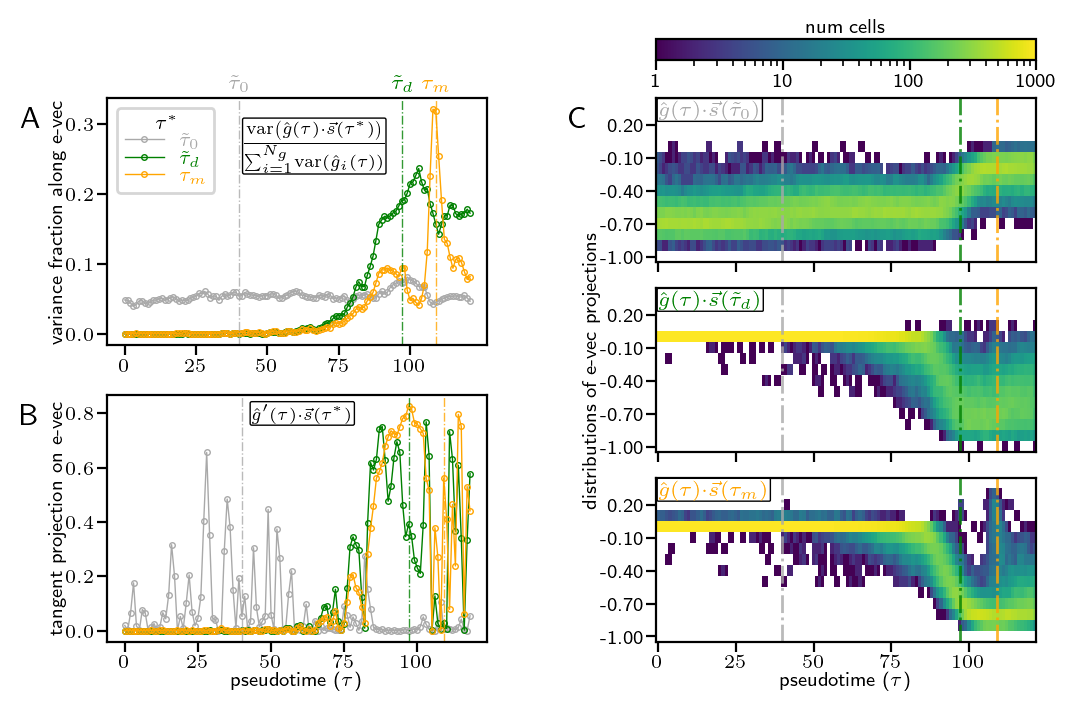

In [26]:
plt.style.reload_library()
plt.style.use('{0}/sty/one_col_fig_7.mplstyle'.format(papdir))
plt.rcParams['grid.color'] = "lightgray"

wfrac, hfrac = 4,4

left_marg_wid = 1
awid = 8
ab_spc = 3.5
bwid = awid

bleg_ht = 0.5
bleg_spc = 0.75
b1_ht = 3.5
b12_spc = 0.5
a_ht = 5.25
ac_spc = 1
b2_ht = b1_ht
b23_spc = b12_spc
b3_ht = b1_ht
#c_ht = a_ht

wds = np.array([
    left_marg_wid,
    awid,
    ab_spc,
    bwid
])
h1 = a_ht-b12_spc-b1_ht 
hts = np.array([
    bleg_ht,
    bleg_spc,
    b1_ht,
    b12_spc,
    h1,
    ac_spc,
    b2_ht - ac_spc - h1, 
    b23_spc,
    b3_ht
])

wds = np.array(wfrac*wds,dtype = int)
hts = np.array(hfrac*hts,dtype = int)

rs = np.cumsum(hts) # starting rows
cs = np.cumsum(wds) # starting cols

nr = np.sum(hts)
nc = np.sum(wds)

wid = 16/2.54
ht  = wid*nr/nc


fig = plt.figure(figsize=(wid, ht), dpi=200)

gs = gridspec.GridSpec(nr, nc)

axA  = plt.subplot( gs[rs[1]:rs[4], cs[0]:cs[1]])
axBL = plt.subplot( gs[0:rs[0],     cs[2]:cs[3]])
axB1 = plt.subplot( gs[rs[1]:rs[2], cs[2]:cs[3]])
axB2 = plt.subplot( gs[rs[3]:rs[6], cs[2]:cs[3]])
axB3 = plt.subplot( gs[rs[7]:rs[8], cs[2]:cs[3]])
axC  = plt.subplot( gs[rs[5]:rs[8], cs[0]:cs[1]])

caps = ['A','C','B']

rcxy = [
    [rs[1], 0, -2, -4], #A
    [rs[1], cs[1] , -2, 8], #B
    [rs[5], 0, -2, -4] #C
]

for i in range(len(caps)):
    r,c,dr,dc = rcxy[i]
    cap_ax=plt.subplot(gs[r:r+1,c:c+1])
    cap_ax.text(s=caps[i], x=dc, y=dr,fontsize=11, fontweight='bold')
    cap_ax.axis('off')

props0 = dict(boxstyle='round, pad=0.1', alpha=1, facecolor='white', edgecolor='black',linewidth=0.5)
props1 = dict(boxstyle='round, pad=0.05', alpha=1, facecolor='white', edgecolor='black',linewidth=0.5)
props2 = dict(boxstyle='round, pad=0', facecolor='white', alpha=1, edgecolor='none')

bifnms = [r'$\tilde{\tau}_{0}$',r'$\tilde{\tau}_{d}$',r'$\tau_{m}$']
tlabs1 = [mulens+r'$\tau^*=$'+ x for x in bifnms]
tlabs2 = [mulens+r'$\hat{g}(\tau)\cdot\vec{s}($'+x+r'$)$' for x in bifnms]



##### A #####
#### % of explained variance #######
bift_labs = [r'$\tilde{\tau}_0$',r'$\tilde{\tau}_d$',r'$\tau_m$']
for i in range(3):
    axA.plot(pst_evec_var[i]/gexp_total_var,'o-', color=bcol[i], label=bift_labs[i], fillstyle='none',markersize=2,markeredgewidth=0.5,linewidth=0.5)
#axA.set_xlabel(pst_ax_label)
axA.set_ylabel(r'variance fraction along e-vec')
axA.text(s=mulens+r'\[ \frac{{\rm var}\left(\hat{g}(\tau)\cdot\vec{s}(\tau^*)\right)}{\sum_{i=1}^{N_g}{{\rm var}\left(\hat{g}_i(\tau)\right)}}\]', 
         x=0.36,y=0.8, transform=axA.transAxes,fontsize=6,bbox=props0)
axA.legend(labelcolor='linecolor',title=r'$\tau^*$',labelspacing=0,title_fontsize=7)

#axA.set_ylabel(r'variance fraction along e-vec'+'\n'+mulens+r'var($\hat{g}(\tau)\cdot\vec{s}(\tau^*)/\sum{var(\hat{g}_i(\tau))}$')

###### C tangenet vector #####
for i in range(3):
    axC.plot(bift_evec_mutan_proj[:,i]**2,'o-', color=bcol[i], label=bift_labs[i],fillstyle='none',markersize=2,markeredgewidth=0.5,linewidth=0.5)
axC.set_xlabel(pst_ax_label)
axC.set_ylabel('tangent projection on e-vec')
axC.text(s=mulens+r'\[ \hat{g}^\prime(\tau)\cdot\vec{s}(\tau^*)\]', x=0.38,y=0.9, transform=axC.transAxes,fontsize=6,bbox=props0)

for ax in [axA,axC]:
    ax.set_xticks([0,25,50,75,100])
#axC.set_ylabel(r'projection of $\vec{s}(\tau^*)$ onto mean expression'+'\n'+r'$(\hat{g\'}(\tau)\cdot\vec{s}(\tau^*))$')

########### B ###############
##############################################
# 1d distributions...########################
###############################################
log_bif_proj_hists = [np.log10(x, out = np.zeros_like(x)+np.nan, where=x>0) for x in bif_proj_hists]
formatter = LogFormatter(10, labelOnlyBase=False) 
colnorm = matplotlib.colors.LogNorm(vmin=1, vmax=1000)


#axs[0].set_xticklabels([])

ylabs = [r'$\hat{g}(\tau)\cdot\vec{s}(\tau_d)$',
         r'$\hat{g}(\tau)\cdot\vec{s}(\tau_m)$']

tick_skip = 3
nbin = bif_proj_hists.shape[1]
pmin = -1.1
pmax = 0.4
bmin = np.argmin(np.abs(hbin_mids[0] - pmin))
bmax = np.argmin(np.abs(hbin_mids[0] - pmax))+1

props1 = dict(boxstyle='round, pad=0.05', alpha=1, facecolor='white', edgecolor='black',linewidth=0.5)
props2 = dict(boxstyle='round, pad=0', facecolor='white', alpha=1, edgecolor='none')

for i,ax in enumerate([axB1, axB2, axB3]):
    im = ax.imshow(bif_proj_hists[i,:,bmin:bmax].T,aspect='auto',norm=colnorm, zorder=2, origin='lower')

    #ax.set_ylabel(ylabs[i])
    ax.set_yticks(np.arange(0,len(hbin_mids[i,bmin:bmax]),tick_skip))
    ax.set_yticklabels(['{0:.2f}'.format(x) for x in hbin_mids[i,bmin:bmax:tick_skip]])
    # ax.text(s=tlabs1[i], x=0.005, y=0.99, transform=ax.transAxes, verticalalignment='top', 
    #         horizontalalignment='left', bbox=props1, fontsize=7.5, color=bcol[i])
    ax.text(s=tlabs2[i], x=0.005, y=0.99, transform=ax.transAxes, verticalalignment='top', 
            horizontalalignment='left', bbox=props1, fontsize=7.5, color=bcol[i])
    
    if i < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(pst_ax_label)


plt.colorbar(im, cax=axBL, orientation='horizontal', format=formatter)
axBL.set_title('num cells')

tau_min  = np.array([0,0])
tau_min  = np.vstack([tau_min, tau_min]).T
lss      = ['-.','-.','-.']
bifxs  = evec_ts2 #(np.array([evec_]) - tau_min)/(npst - tau_min) #[0.8,0.6] #bifts / tf
lws = [0.5,0.5,1,1,1]
for j in range(nevec):
    # axB1.text(s=bift_labs[j],x=evec_ts2[j]/npst,y=.99,transform=axB1.transAxes, color=bcol[j],
    #              horizontalalignment = 'center', verticalalignment='top',fontsize=7.5, bbox=props2)
    axA.text(s=bift_labs[j],x=evec_ts2[j],y=0.345, color=bcol[j],
                 horizontalalignment = 'center', verticalalignment='bottom',fontsize=7.5, bbox=props2)
    for i,ax in enumerate([axA,axC,axB1, axB2, axB3]):
        ax.axvline(evec_ts2[j],linestyle = lss[j], alpha=0.8,zorder=2,lw=lws[i], color=bcol[j])
        
axB2.set_ylabel(r'distributions of e-vec projections')
plt.savefig('{0}/figS12_evec_proj_dists.pdf'.format(figdir), bbox_inches='tight')

        
        


In [27]:
gexp_sn       = gexp_full[bin_cidxs[evec_ts[2]]]
gexp_sn_ctr   = gexp_sn - np.mean(gexp_sn, axis=0)
gexp_sn_norms = np.linalg.norm(gexp_sn_ctr, axis=0)
gexp_sn_normd = np.divide(gexp_sn_ctr, gexp_sn_norms, where = gexp_sn_norms > 0, out=np.zeros_like(gexp_sn_ctr))
#fth1_ccs = gexp_sn_normd[:,gidxs[3]].T.dot(gexp_sn_normd)

In [28]:
ngs = 24
gidxs2 = np.argsort(-pst_pc1_sq[evec_ts[2]])[0:ngs]
gdats  = gexp_sn[:,gidxs2].T
gmins  = np.array([np.amin(gdat[gdat>0]) for gdat in gdats])
gmaxs  = np.amax(gdats, axis=1)
gmaxs = gmaxs + gmins # like adding epsilon..

nbins  = 20
gbins_lin   = np.array([np.hstack([[-gmins[i]],np.linspace(gmins[i],gmaxs[i], nbins)]) for i in range(ngs)])
gbins_log   = np.array([np.hstack([[-gmins[i]],np.logspace(np.log10(gmins[i]),np.log10(gmaxs[i]), nbins)]) 
                        for i in range(ngs)])

gbin_ctrs_lin = 0.5*(gbins_lin[:,1:]+gbins_lin[:,:-1])
gbin_ctrs_log = 0.5*(gbins_log[:,1:]+gbins_log[:,:-1])

ghists_lin    = np.array([np.histogram(gdats[i], bins=gbins_lin[i])[0] for i in range(ngs)])
ghists_log    = np.array([np.histogram(gdats[i], bins=gbins_log[i])[0] for i in range(ngs)])

ghists_lin_split    = np.array([[np.histogram(gdats[i,gmm_pred_idxs[evec_ts[2]][j]], bins=gbins_lin[i])[0] 
                                                    for j in range(nbranch)]
                                              for i in range(ngs)])
                                 
ghists_log_split    = np.array([[np.histogram(gdats[i,gmm_pred_idxs[evec_ts[2]][j]], bins=gbins_log[i])[0] 
                                                    for j in range(nbranch)]
                                              for i in range(ngs)])

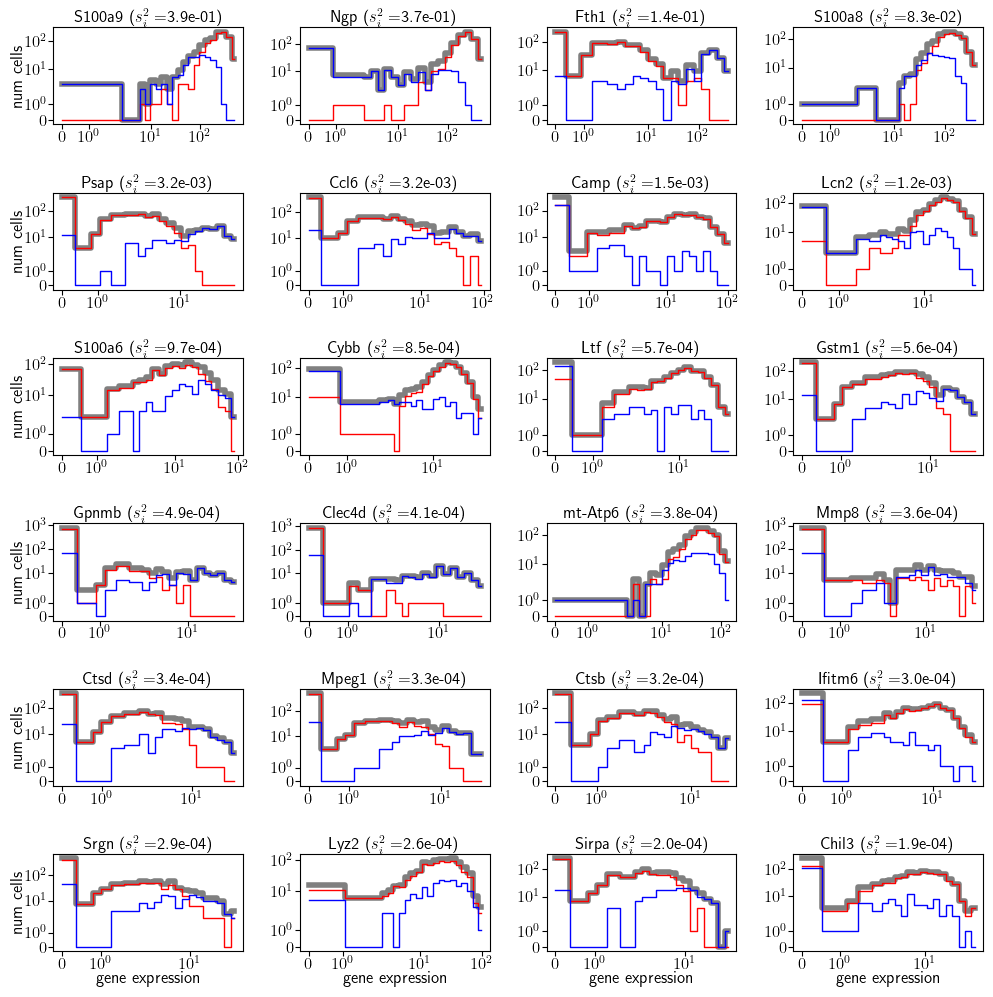

In [29]:
nrow = 6
ncol = int(np.ceil(ngs/nrow))
fig,axs=plt.subplots(nrow,ncol,figsize=(12,12))

for i,t in enumerate(gidxs2):
    
    r,c = int(i/ncol), i%ncol
    ax  = axs[r,c]
    axs[r,c].step(gbin_ctrs_log[i], ghists_log[i], where='mid', color='gray', linewidth=4)
    
    for j in range(nbranch):
        ax.step(gbin_ctrs_log[i], ghists_log_split[i,j], where='mid', color = clust_cols[j])

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title('{0} ($s_i^2=${1:.1e})'.format(gnms[gidxs2[i]],pst_pc1_sq[evec_ts[2], gidxs2[i]]))
    
    if r == nrow-1:
        ax.set_xlabel('gene expression')
    if c == 0:
        ax.set_ylabel('num cells')
    
    mf.set_axs_fontsize(ax, 12)

plt.subplots_adjust(hspace=0.7,wspace=0.3)
plt.savefig('{0}/figS13_clust_gene_distr.pdf'.format(figdir), bbox_inches='tight')


In [30]:
nclust = 2
gmm_cov_eval = np.array([[
    PCA(n_components=1).fit(gexp_full[bin_cidxs[t][gmm_pred_idxs[t][i]]]).explained_variance_[0] 
    if len(gmm_pred_idxs[t][i])>0 else np.nan for i in range(nclust)] for t in range(nt)]
    )

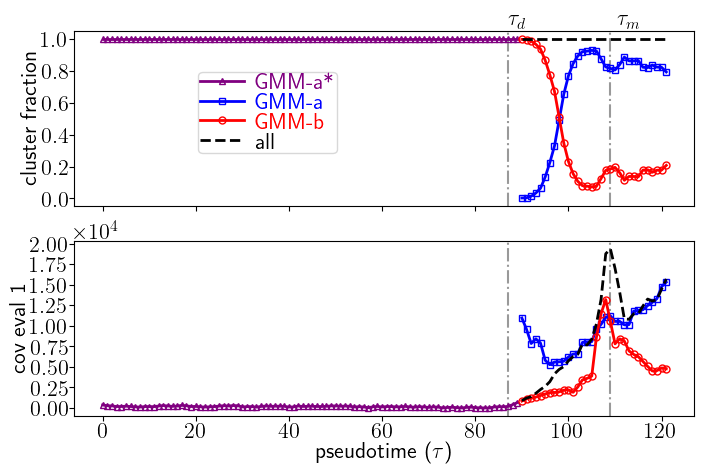

In [31]:
fig,axs=plt.subplots(2,1, figsize=(8,5))

##########################
######axs[1]: eval plot ##
##########################

clust_cols = ['red', 'blue']
colsF      = np.array(['purple','black']+clust_cols)
clabs      = np.array(['GMM-a*', 'all', 'GMM-b', 'GMM-a'])
mstyles    = ['^-','--','o-','s-'] 

clust1_frac   = nc1/nc_all
pst_eig1_n    = pst_eig1 - np.amin(pst_eig1)
clust1_eig1_n = gmm_cov_eval[:,1]-np.nanmin(gmm_cov_eval[:,1])
clust0_eig1_n = gmm_cov_eval[:,0]
fs = 16
trngs      = [np.arange(t0), np.arange(t0,npst), np.arange(t0,npst), np.arange(t0,npst)]
dats0      = [clust1_frac[0:t0], np.ones(npst-t0), clust1_frac[t0:], 1-clust1_frac[t0:]]
dats1      = [pst_eig1_n[0:t0], pst_eig1_n[t0:], clust1_eig1_n[t0:], clust0_eig1_n[t0:]]

dats = [dats0, dats1]
dord = [0,3,2,1]
#nclust_cell = []

for i in range(len(dats)):
    for j in dord:
        axs[i].plot(trngs[j], dats[i][j], mstyles[j], color=colsF[j], label = clabs[j], lw=2, markersize=5, 
                    fillstyle='none')

axs[0].legend(labelspacing=0, labelcolor=colsF[dord], handletextpad=0.5, 
           frameon=True, framealpha=0.75, borderpad=0.05, fontsize=fs, loc=(0.2,0.3))

axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[1].yaxis.get_offset_text().set_fontsize(fs)

axs[1].set_xlabel(r'pseudotime ($\tau$)')
axs[0].set_ylabel('cluster fraction')
axs[1].set_ylabel('cov eval 1')

axs[1].set_xlabel(pst_ax_label)
axs[0].set_xticklabels([])

for ax in axs:
    mf.set_axs_fontsize(ax,16)
    
tau_min  = np.array([0,0])
tau_min  = np.vstack([tau_min, tau_min]).T
lss      = ['-.','-.','-.']
bifnms = [r'$\tau_{d}$',r'$\tau_{m}$']
bifxs  = evec_ts[1:] #(np.array([evec_]) - tau_min)/(npst - tau_min) #[0.8,0.6] #bifts / tf
for j in range(len(evec_ts[1:])):
    axs[0].text(s=bifnms[j],x=evec_ts[j+1]/npst,y=1.01,color='k', transform=axs[0].transAxes,
                 horizontalalignment = 'center', verticalalignment='bottom',fontsize=fs)
    for i,ax in enumerate(axs):
        ax.axvline(evec_ts[j+1],color='k', linestyle = lss[j], alpha=0.4,zorder=0,lw=1.5)

plt.savefig('{0}/figS14_clust_frac_evals.pdf'.format(figdir), bbox_inches='tight')